In [207]:
%load_ext autoreload
%autoreload 2

import torch
import datasets
import nerf2d_env
import nerf2d_utils
from PIL import Image
import numpy as np

from models.fourier_nn import FourierNet
import matplotlib.pyplot as plt

img = torch.tensor(np.asarray(Image.open("../floorplans/32_data/floor_img.png"))) / 255.0

torch.set_default_tensor_type(torch.DoubleTensor)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [208]:
data_conf = {"scan_loc_type": "random", 
        "num_scans": 1500,
        "xlims": [-1.0, 1.0], 
        "ylims":[-1.0, 1.0],
        "t_near": 0.0,
        "t_far": 0.5,
        "num_beams": 32,
        "num_course_data": 128,
        "num_fine_data": 64,
        "num_coarse_train": 48,
        "num_fine_train": 32,
        "importance_samp_data": True,
        "importance_samp_train": True,
        "beam_thresh": 0.0,
        "opacity": 1.0,
        "train_batch_size": 8
        }


In [209]:
device = torch.device("cpu")
nenv = nerf2d_env.NeRF2DEnv(img, device, data_conf)
dataset = datasets.NeRF2DDataset(nenv, device, data_conf)
data_conf["num_scans"] = 500
valset = datasets.NeRF2DDataset(nenv, device, data_conf)

In [210]:
def masked_weighted_loss(target, pred, weight, mask):
    return torch.mean(mask * torch.abs(target - pred) / torch.sqrt(weight.detach() + 1e-2))

def masked_huber_loss(target, pred, weight, mask):
    return torch.mean(mask * torch.nn.HuberLoss(reduction="none", delta=0.2)(target, pred) / torch.sqrt(weight.detach() + 1e-2))

In [211]:
model = FourierNet([2, 186, 32, 32, 32, 1], scale=150.0)
opt = torch.optim.Adam(model.parameters(), lr=0.0005)
dl = torch.utils.data.DataLoader(dataset, batch_size=data_conf["train_batch_size"])

In [212]:
for epoch in range(10):
    losses = []
    for batch in dl:
        pos, d_target, mask = batch
        opt.zero_grad()
    
        d_mean, d_var = nerf2d_utils.neural_render(
                            model, pos, nenv.lidar, 
                            data_conf["num_coarse_train"], data_conf["num_fine_train"],
                            data_conf["importance_samp_train"]
                            )    
            
        loss = masked_weighted_loss(d_target, d_mean, d_var, mask)
        loss.backward()
        opt.step()
        
        losses.append(loss.data)
    losses = torch.Tensor(losses)
    print("train loss: ", torch.mean(losses))
    
    valloader = torch.utils.data.DataLoader(valset, batch_size=20)
    valloss = 0.0
    
    with torch.no_grad():
        for batch in valloader:
            pos, d_target, mask = batch
            d_mean, d_var = nerf2d_utils.neural_render(
                                model, pos, nenv.lidar, 
                                data_conf["num_coarse_train"], data_conf["num_fine_train"],
                                data_conf["importance_samp_train"]
                                )    
    
            valloss += (masked_weighted_loss(d_target, d_mean, d_var, mask)).data.detach()
    
    print("validation loss: ", valloss)
    

train loss:  tensor(0.2988)
validation loss:  tensor(4.4889)
train loss:  tensor(0.1634)
validation loss:  tensor(3.8762)
train loss:  tensor(0.1372)
validation loss:  tensor(3.4928)
train loss:  tensor(0.1304)
validation loss:  tensor(3.4701)
train loss:  tensor(0.1173)
validation loss:  tensor(3.3373)
train loss:  tensor(0.1149)
validation loss:  tensor(2.9374)
train loss:  tensor(0.1074)
validation loss:  tensor(2.6789)
train loss:  tensor(0.0989)
validation loss:  tensor(2.7270)
train loss:  tensor(0.0952)
validation loss:  tensor(2.7206)
train loss:  tensor(0.0948)
validation loss:  tensor(2.3795)


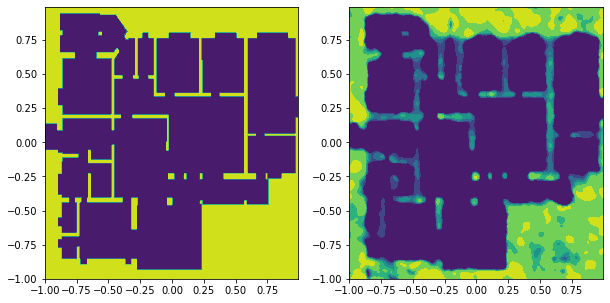

In [213]:
pdens = model.forward(nenv.mesh_inputs)
gt = nenv.gi((nenv.mesh_inputs[:, 0], nenv.mesh_inputs[:, 1]))

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.tricontourf(nenv.mesh_inputs[:, 0], nenv.mesh_inputs[:, 1], gt)
pts, _, _ = nenv.lidar.generate_scan_points(torch.zeros((1, 2)), num_points=32)
pts = pts.reshape(-1, 2)
#ax0.scatter(dataset.scan_locs[:, 0], dataset.scan_locs[:, 1])


ax1.tricontourf(nenv.mesh_inputs[:, 0], nenv.mesh_inputs[:, 1], pdens.detach().squeeze())
